This notebook is to test the movement and rewards of the environment 

In [ ]:
from til_environment import gridworld
from til_environment.types import RewardNames
import matplotlib.pyplot as plt
import numpy as np

In [42]:
"""
note that the default rewards of the environment do not work since the default scores for guards is practically +50 only if scout is captured 

this only reward is restrictive and would be hard for the guard to train since there is only 1 signal and thus have no incentive to move 

the most simplest fix is to add penalty for no movement / movement to walls 

"""

custom_rewards = {
    RewardNames.GUARD_CAPTURES: 100,     
    RewardNames.SCOUT_CAPTURED: -100,    
    RewardNames.SCOUT_RECON: 2,         
    RewardNames.SCOUT_MISSION: 10,      
    RewardNames.WALL_COLLISION: -5,       # experiemnt with this 
    RewardNames.STATIONARY_PENALTY: -1, 
    RewardNames.SCOUT_STEP: -0.1,         # small step penalty to encourage efficiency
    RewardNames.GUARD_STEP: -0.1,         # same for guards 
}

RENDER_MODE = 'rgb_array'

env = gridworld.env(
    env_wrappers=[],
    render_mode=RENDER_MODE,  
    debug=True, 
    novice=False, 
    rewards_dict=custom_rewards  
)

env.reset(seed=42)

In [43]:
# track 
agent_rewards = {agent: [] for agent in env.possible_agents}
scout_actions = []
guard_actions = []
step_count = 0
total_rewards = {agent: 0 for agent in env.possible_agents}

print("agent step by step rewards ---> ", agent_rewards)
print("agents total rewards ---> ", total_rewards)

# check roles 
print("scout --->", env.scout)

agent step by step rewards --->  {'player_0': [], 'player_1': [], 'player_2': [], 'player_3': []}
agents total rewards --->  {'player_0': 0, 'player_1': 0, 'player_2': 0, 'player_3': 0}
scout ---> player_0


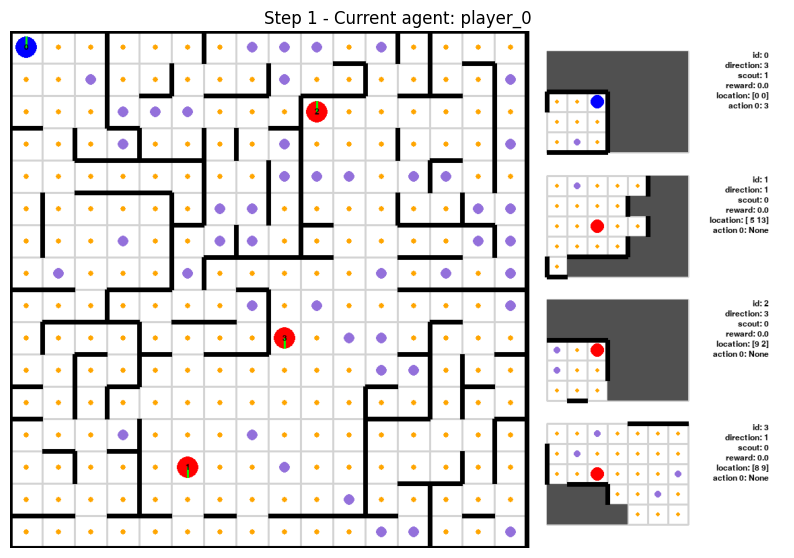

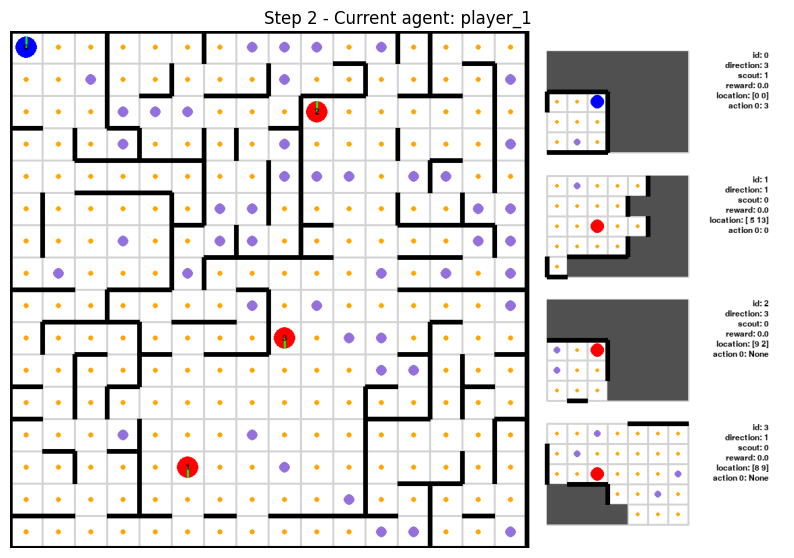

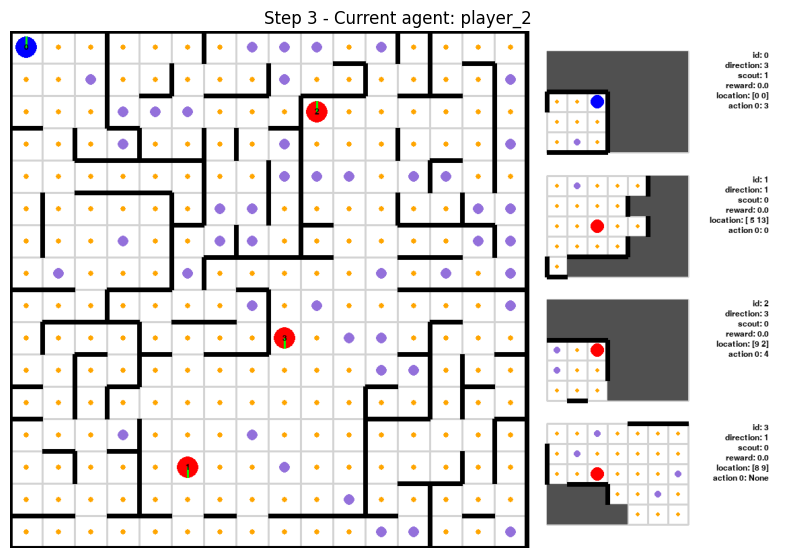

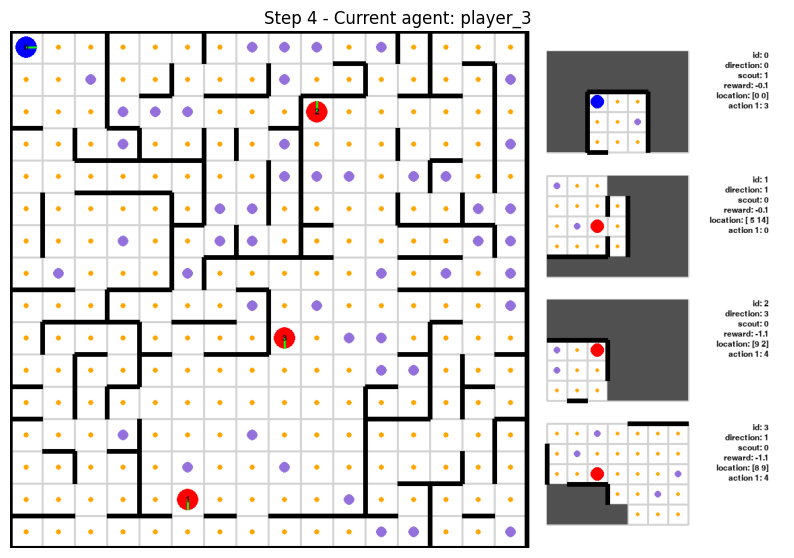

Step 4: player_0 received reward: -0.1
Location: [0 0]
Scout status: 1

Step 5: player_1 received reward: -0.1
Location: [ 5 14]
Scout status: 0

Step 6: player_2 received reward: -1.1
Location: [9 2]
Scout status: 0

Step 7: player_3 received reward: -1.1
Location: [8 9]
Scout status: 0

Step 8: player_0 received reward: 1.9
Location: [1 0]
Scout status: 1

Step 9: player_1 received reward: -0.1
Location: [ 5 14]
Scout status: 0



In [44]:
"""
class Action(IntEnum):
    FORWARD = 0
    BACKWARD = 1
    LEFT = 2
    RIGHT = 3
    STAY = 4

class Direction(IntEnum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3

actions and directions are based on the relative position 

if face right and move forward => move right 

if face right and turn right => now faces downwards 

"""

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()
    
    if termination or truncation:
        print(f"Final step: {step_count}")
        break
    
    # track cur agent rewards 
    agent_rewards[agent].append(reward)
    total_rewards[agent] += reward
    
    if reward != 0:
        print(f"Step {step_count}: {agent} received reward: {reward}")
        print(f"Location: {observation['location']}")
        print(f"Scout status: {observation['scout']}") # scout flag 
        print()
    
    # some random policy 
    if observation['scout'] == 1:  

        # randomly turn sometimes 
        if np.random.random() < 0.5:
            action = np.random.choice([2, 3])  

        # else just go forwrad 
        else:
            action = 0  #
        scout_actions.append(action)

    else: 
        # just sample some random action since rewards are more for scout testing 
        action = env.action_space(agent).sample()
        guard_actions.append(action)
    
    env.step(action)
    step_count += 1

    if RENDER_MODE == 'rgb_array' and step_count < 5:
        frame = env.render()
        plt.figure(figsize=(10, 8))
        plt.imshow(frame)
        plt.title(f"Step {step_count} - Current agent: {agent}")
        plt.axis("off")
        plt.show()

    if step_count == 10:
        break

In [47]:
print("agent step by step rewards ---> ", agent_rewards)
print("agents total rewards ---> ", total_rewards)
print("scount actions --->", scout_actions)
print(f"scout is {env.scout}")

agent step by step rewards --->  {'player_0': [0, -0.1, 1.9], 'player_1': [0, -0.1, -0.1], 'player_2': [0, -1.1], 'player_3': [0, -1.1]}
agents total rewards --->  {'player_0': 1.7999999999999998, 'player_1': -0.2, 'player_2': -1.1, 'player_3': -1.1}
scount actions ---> [np.int64(3), 0, np.int64(3)]
scout is player_0


From the above , can see agent does move, so methods are working ok 

In [51]:
# test collisions 
env = gridworld.env(
    env_wrappers=[],
    render_mode=None,
    debug=False,
    novice=True,
    rewards_dict={RewardNames.WALL_COLLISION: -10}
)
env.reset(seed=42)

collision_rewards = []
for i, agent in enumerate(env.agent_iter()):
    if i > 20:  
        break
        
    observation, reward, termination, truncation, info = env.last()
    if termination or truncation:
        break
    
    # spam forward movement 
    action = 0  
    env.step(action)
    
    if reward < 0:
        collision_rewards.append(reward)
        print(f"agent -> {agent}, wall collision -> {reward}")

env.close()

agent -> player_0, wall collision -> -10
agent -> player_0, wall collision -> -10
agent -> player_1, wall collision -> -10
agent -> player_0, wall collision -> -10
agent -> player_1, wall collision -> -10
agent -> player_3, wall collision -> -10
agent -> player_0, wall collision -> -10
agent -> player_1, wall collision -> -10
agent -> player_2, wall collision -> -10
agent -> player_3, wall collision -> -10
agent -> player_0, wall collision -> -10


In [52]:
env = gridworld.env(
    env_wrappers=[],
    render_mode=None,
    debug=False,
    novice=True,
    rewards_dict={RewardNames.STATIONARY_PENALTY: -2}
)
env.reset(seed=42)

stationary_rewards = []
for i, agent in enumerate(env.agent_iter()):
    if i > 20:  
        break
        
    observation, reward, termination, truncation, info = env.last()
    if termination or truncation:
        break
        
    # stay action 
    action = 4  
    env.step(action)
    
    if reward != 0:
        stationary_rewards.append(reward)
        print(f"agent -> {agent}, reward -> {reward}")

env.close()


agent -> player_0, reward -> -2
agent -> player_1, reward -> -2
agent -> player_2, reward -> -2
agent -> player_3, reward -> -2
agent -> player_0, reward -> -2
agent -> player_1, reward -> -2
agent -> player_2, reward -> -2
agent -> player_3, reward -> -2
agent -> player_0, reward -> -2
agent -> player_1, reward -> -2
agent -> player_2, reward -> -2
agent -> player_3, reward -> -2
agent -> player_0, reward -> -2
agent -> player_1, reward -> -2
agent -> player_2, reward -> -2
agent -> player_3, reward -> -2
agent -> player_0, reward -> -2
